## Assignment 7: Medical Text Classification (NLP)
This task involves creating clasiffy patient transcriptions into 4 categories:
- Surgery
- Medical Records
- Internal Medicine
- Other

I have been given the following data files:
- X.csv: A fully processed dataset. Simplified to 4 classes
- classes.txt: Text file describing the dataset's classes: Surgery, Medical Records, Internal Medicine and Other
- train.csv: Training data subset. Contains 90% of the X.csv processed file.
- Test data subset. Contains 10% of the X.csv processed file.

I'm also given the following data source files:
- mtsamples.csv: Compiled from Kaggle's medical transcriptions dataset by Tara Boyle, scraped from Transcribed Medical Transcription Sample Reports and Examples
- clinical-stopwords.txt: Compiled from Dr. Kavita Ganesan clinical-concepts repository. See the Discovering Related Clinical Concepts Using Large Amounts of Clinical Notes paper.
- vocab.txt: Generated vocabulary text files for Natural Language Processing (NLP) using the Systematized Nomenclature of Medicine International (SNMI) data.

In [2]:
# Library Imports
import pandas as pd
from gensim.models import Word2Vec
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F

In [3]:
# Load the data

# datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Load stopwords and vocabulary
with open('clinical-stopwords.txt', 'r') as file:
    stopwords = file.read().splitlines()

# Remove leading and trailing special characters from stopwords
stopwords = [word.strip("#") for word in stopwords if word not in ["", " ", "\n"]]

with open('vocab.txt', 'r') as file:
    vocab = file.read().splitlines()

# Clean and preprocess vocab words
vocab = [word.lower().strip() for word in vocab if word not in ["", " ", "\n"]]
    

In [4]:
# Load the stop words and vocabulary
with open('clinical-stopwords.txt', 'r') as file:
    stopwords = file.read().splitlines()

# Remove leading and trailing special characters from stopwords
stopwords = [word.strip("#") for word in stopwords if word not in ["", " ", "\n"]]

with open('vocab.txt', 'r') as file:
    vocab = file.read().splitlines()

# Clean and preprocess vocab words
vocab = [word.lower().strip() for word in vocab if word not in ["", " ", "\n"]]

# Convert stopwords and vocab lists to sets for faster lookup
stopwords_set = set(stopwords)
vocab_set = set(vocab)

### 1. Data Preprocessing

In [5]:
# Function to clean and tag text with stopwords and vocab
def preprocess_and_tag(text, stopwords_set, vocab_set):
    # Convert to lowercase and split text into words
    words = text.lower().split()
    # Remove stopwords and keep only vocab words
    filtered_words = [word for word in words if word not in stopwords_set and word in vocab_set]
    return ' '.join(filtered_words)

In [6]:
# Apply preprocessing to train and test data as a new column
train_df['cleaned_text'] = train_df['text'].apply(lambda x: preprocess_and_tag(x, stopwords_set, vocab_set))
test_df['cleaned_text'] = test_df['text'].apply(lambda x: preprocess_and_tag(x, stopwords_set, vocab_set))

In [7]:
# combine train and test data (this is for training the word2vec model to ensure that the model is trained on all the data)
text_data = list(train_df['cleaned_text']) + list(test_df['cleaned_text'])
tokenized_data = [text.split() for text in text_data]

In [8]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

# Example of enhanced text cleaning (simplified for demonstration)
def clean_text(text):
    text = text.lower()
    # Add more cleaning steps here as needed
    return text

# Use NLTK's tokenizer for more robust tokenization
def tokenize_and_remove_stopwords(text, stopwords_set):
    tokens = word_tokenize(text)
    filtered_tokens = [token for token in tokens if token not in stopwords_set]
    return filtered_tokens

# Updated preprocessing to include tokenization and enhanced cleaning
def preprocess_and_tag_enhanced(text, stopwords_set, vocab_set):
    cleaned_text = clean_text(text)
    tokens = tokenize_and_remove_stopwords(cleaned_text, stopwords_set)
    # Keep only vocab words
    filtered_tokens = [token for token in tokens if token in vocab_set]
    return ' '.join(filtered_tokens)

# Apply enhanced preprocessing
train_df['cleaned_text'] = train_df['text'].apply(lambda x: preprocess_and_tag_enhanced(x, stopwords_set, vocab_set))
test_df['cleaned_text'] = test_df['text'].apply(lambda x: preprocess_and_tag_enhanced(x, stopwords_set, vocab_set))

# Adjusting sequence length for RNN input
def adjust_sequence_length(tokenized_texts, desired_len=300):
    # Truncate or pad the sequences as needed
    adjusted_texts = []
    for tokens in tokenized_texts:
        if len(tokens) > desired_len:
            adjusted = tokens[:desired_len]  # Truncate
        else:
            adjusted = tokens + ['<PAD>'] * (desired_len - len(tokens))  # Pad
        adjusted_texts.append(adjusted)
    return adjusted_texts

# Adjusting sequences to a fixed length
tokenized_data= adjust_sequence_length(tokenized_data)


[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1002)>


In [9]:
# Generate document Embeddings

# Train the word2vec model
w2v_model = Word2Vec(sentences=tokenized_data, vector_size=300, window=5, min_count=1, workers=4)

# Function to average the word vectors in a document
def document_embedding(text, model):
    words = text.split()
    # Filter words to ensure they are in the model's vocabulary
    words = [word for word in words if word in model.wv]
    if not words:
        # If no words in the document are in the vocabulary, return a zero vector
        return np.zeros(model.vector_size)
    # Compute average embedding
    embedding = np.mean([model.wv[word] for word in words], axis=0)
    return embedding

In [10]:
# apply the document embedding function to the cleaned text for train and test data
train_df['embedding'] = train_df['cleaned_text'].apply(lambda x: document_embedding(x, w2v_model))
test_df['embedding'] = test_df['cleaned_text'].apply(lambda x: document_embedding(x, w2v_model))

In [11]:
# Adjusting the labels to be zero-indexed since they start from 1
train_df['label'] = train_df['label'] - 1
test_df['label'] = test_df['label'] - 1


### 2. Prep Dataset for Learning

In [12]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Example conversion of embeddings and labels to tensors
train_features = torch.tensor(train_df['embedding'].tolist())
train_labels = torch.tensor(train_df['label'].values)
test_features = torch.tensor(test_df['embedding'].tolist())
test_labels = torch.tensor(test_df['label'].values)

# Ensure your tensors are of float type for features and long (int) for labels if you're doing classification
train_features = train_features.float()
test_features = test_features.float()
train_labels = train_labels.long()
test_labels = test_labels.long()

# Create TensorDatasets
train_dataset = TensorDataset(train_features, train_labels)
test_dataset = TensorDataset(test_features, test_labels)

# Create DataLoaders
batch_size = 128  # You can adjust the batch size
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

/var/folders/fc/pwfmg_jd7k9d9mxgnl_clxr00000gn/T/ipykernel_45196/325828268.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  train_features = torch.tensor(train_df['embedding'].tolist())


In [13]:
import torch

# Counts for each class
class_counts = torch.tensor([1442, 1126, 1040, 891], dtype=torch.float)

# Calculate class weights
total_count = class_counts.sum()
num_classes = len(class_counts)
class_weights = total_count / (num_classes * class_counts)

# If you're using a GPU, you might want to move the weights to the same device as your model and data
class_weights = class_weights.to('cuda' if torch.cuda.is_available() else 'cpu')

print("Class weights:", class_weights)


Class weights: tensor([0.7800, 0.9989, 1.0815, 1.2623])


### 3. First Model: Plain Vanilla Neural Network

In [54]:
# Deffine the NN
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Define the NN architecture
class SimpleNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64) # First layer
        self.fc2 = nn.Linear(64, 32)        # Second layer
        self.fc3 = nn.Linear(32, output_dim)# Output layer
        
    def forward(self, x):
        x = F.relu(self.fc1(x)) # Activation function for first layer
        x = F.relu(self.fc2(x)) # Activation function for second layer
        x = self.fc3(x)         # No activation for output layer in forward pass
        return x

# Initialize model, loss, and optimizer
input_dim = 300    # Embedding dimension
output_dim = 4     # Number of classes
model = SimpleNN(input_dim, output_dim)
criterion = nn.CrossEntropyLoss(weight = class_weights) # added class weights to the loss function
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)



Epoch 1/100, Training Loss: 1.3842, Training Accuracy: 30.01%, Validation Loss: 1.3763, Validation Accuracy: 45.00%
Epoch 2/100, Training Loss: 1.3702, Training Accuracy: 48.48%, Validation Loss: 1.3601, Validation Accuracy: 51.60%
Epoch 3/100, Training Loss: 1.3488, Training Accuracy: 50.83%, Validation Loss: 1.3287, Validation Accuracy: 51.20%
Epoch 4/100, Training Loss: 1.3116, Training Accuracy: 51.97%, Validation Loss: 1.2761, Validation Accuracy: 52.00%
Epoch 5/100, Training Loss: 1.2511, Training Accuracy: 51.77%, Validation Loss: 1.2079, Validation Accuracy: 52.00%
Epoch 6/100, Training Loss: 1.1932, Training Accuracy: 52.37%, Validation Loss: 1.1594, Validation Accuracy: 53.40%
Epoch 7/100, Training Loss: 1.1447, Training Accuracy: 52.34%, Validation Loss: 1.1193, Validation Accuracy: 52.20%
Epoch 8/100, Training Loss: 1.1123, Training Accuracy: 52.43%, Validation Loss: 1.0865, Validation Accuracy: 51.00%
Epoch 9/100, Training Loss: 1.0811, Training Accuracy: 52.19%, Validatio

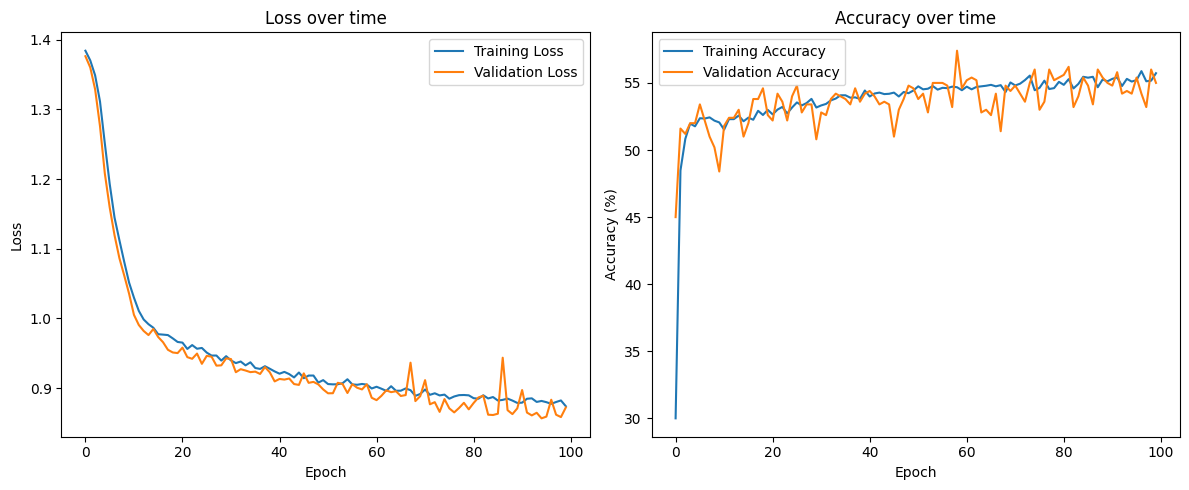

In [55]:
import matplotlib.pyplot as plt

EPOCHS = 100
training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for vectors, targets in trainloader:
        optimizer.zero_grad()
        outputs = model(vectors)
        loss = criterion(outputs, targets)
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        loss.backward()
        optimizer.step()
    training_losses.append(total_loss / len(trainloader))
    training_accuracies.append(100 * correct / total)
    
    # Validation
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for vectors, targets in testloader:
            outputs = model(vectors)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    validation_losses.append(total_loss / len(testloader))
    validation_accuracies.append(100 * correct / total)

    print(f'Epoch {epoch+1}/{EPOCHS}, Training Loss: {training_losses[-1]:.4f}, Training Accuracy: {training_accuracies[-1]:.2f}%, Validation Loss: {validation_losses[-1]:.4f}, Validation Accuracy: {validation_accuracies[-1]:.2f}%')

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Loss over time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training_accuracies, label='Training Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.title('Accuracy over time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


### 4. Build the second Model: Recurrent Neural Network

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

class SimpleRNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, num_layers):
        super(SimpleRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # Expecting x to be of shape [batch_size, seq_len, features]
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])  # Use the output of the last time step
        return out

# Initialize the RNN model
input_dim = 1   # Number of features per time step (adjusted for example)
hidden_dim = 64 # RNN hidden dimension
num_layers = 1  # Number of RNN layers
output_dim = 4  # Number of output classes
model = SimpleRNN(input_dim, output_dim, hidden_dim, num_layers)
criterion = nn.CrossEntropyLoss(weight=class_weights)
#optimizer = optim.SGD(model.parameters(), lr=0.05)

# types of optimizers: SGD, Adam, RMSprop, Adagrad, Adadelta, AdamW, SparseAdam, Adamax, ASGD, LBFGS, Rprop
optimizer = optim.Adam(model.parameters(), lr=0.01)



Epoch 1/100, Training Loss: 1.3969, Training Accuracy: 36.85%, Validation Loss: 1.5159, Validation Accuracy: 18.20%
Epoch 2/100, Training Loss: 1.4421, Training Accuracy: 26.67%, Validation Loss: 1.3807, Validation Accuracy: 18.40%
Epoch 3/100, Training Loss: 1.3712, Training Accuracy: 30.98%, Validation Loss: 1.4247, Validation Accuracy: 23.60%
Epoch 4/100, Training Loss: 1.3157, Training Accuracy: 35.39%, Validation Loss: 1.2738, Validation Accuracy: 44.00%
Epoch 5/100, Training Loss: 1.2414, Training Accuracy: 42.57%, Validation Loss: 1.2031, Validation Accuracy: 50.80%
Epoch 6/100, Training Loss: 1.2030, Training Accuracy: 44.05%, Validation Loss: 1.1350, Validation Accuracy: 52.00%
Epoch 7/100, Training Loss: 1.1562, Training Accuracy: 47.74%, Validation Loss: 1.1051, Validation Accuracy: 51.40%
Epoch 8/100, Training Loss: 1.1539, Training Accuracy: 47.28%, Validation Loss: 1.1440, Validation Accuracy: 49.00%
Epoch 9/100, Training Loss: 1.1116, Training Accuracy: 49.52%, Validatio

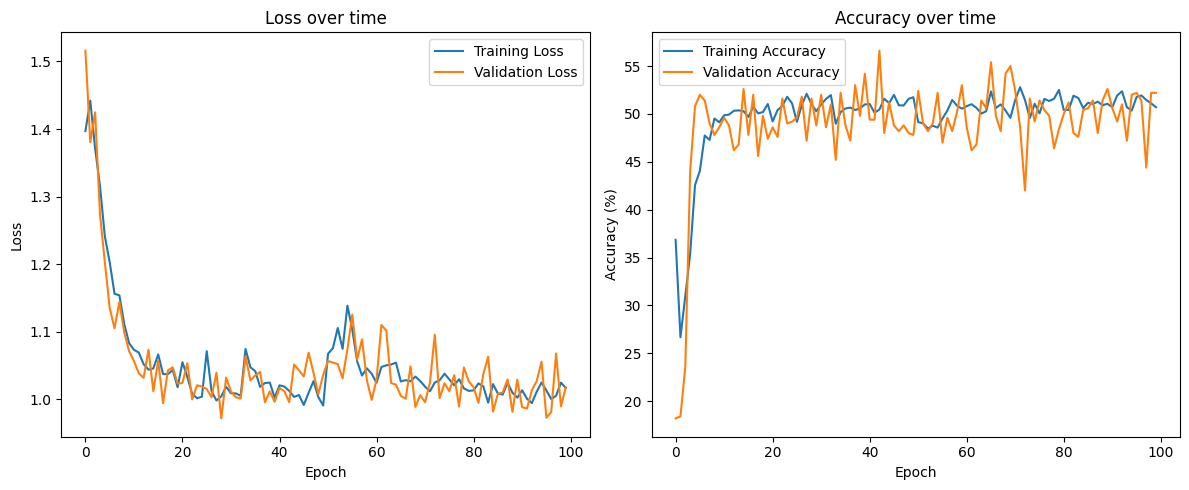

In [43]:
# Training and validation loop
EPOCHS = 100
training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []

for epoch in range(EPOCHS):
    model.train()  # Set the model to training mode
    total_loss = 0
    total = 0
    correct = 0
    for vectors, targets in trainloader:
        vectors_reshaped = vectors.view(vectors.size(0), 300, 1)  # Reshape for RNN
        optimizer.zero_grad()
        outputs = model(vectors_reshaped)
        loss = criterion(outputs, targets)
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        loss.backward()
        optimizer.step()
    
    training_losses.append(total_loss / len(trainloader))
    training_accuracies.append(100 * correct / total)
    
    model.eval()
    total_loss = 0
    total = 0
    correct = 0
    with torch.no_grad():
        for vectors, targets in testloader:
            vectors_reshaped = vectors.view(vectors.size(0), 300, 1)  # Reshape for RNN
            outputs = model(vectors_reshaped)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    validation_losses.append(total_loss / len(testloader))
    validation_accuracies.append(100 * correct / total)

    print(f'Epoch {epoch+1}/{EPOCHS}, Training Loss: {training_losses[-1]:.4f}, Training Accuracy: {training_accuracies[-1]:.2f}%, Validation Loss: {validation_losses[-1]:.4f}, Validation Accuracy: {validation_accuracies[-1]:.2f}%')

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Loss over time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training_accuracies, label='Training Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.title('Accuracy over time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()



### 5. Build the second Model: Convolutional Neural Network

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

class SimpleCNN(nn.Module):
    def __init__(self, seq_len, input_dim, output_dim):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=seq_len, out_channels=64, kernel_size=3, stride=1, padding=1)
        # No pooling layer to avoid reducing sequence length to 0
        self.fc1 = nn.Linear(64 * input_dim, 64) # Adapt based on your actual input dimensions
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_dim)
        
    def forward(self, x):
        x = x.permute(0, 2, 1)  # Adjust to (batch, channels, length) for Conv1d
        x = F.relu(self.conv1(x))
        # No pooling here
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Adjustments in model initialization
seq_len = 300  # Assuming 300 is the sequence length
input_dim = 1   # Assuming each sequence step has 1 dimension
output_dim = 4  # Number of output classes
model = SimpleCNN(seq_len, input_dim, output_dim)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

Epoch 1/100, Training Loss: 1.3948, Training Accuracy: 32.05%, Validation Loss: 1.3764, Validation Accuracy: 39.60%
Epoch 2/100, Training Loss: 1.3938, Training Accuracy: 32.05%, Validation Loss: 1.3764, Validation Accuracy: 39.60%
Epoch 3/100, Training Loss: 1.3914, Training Accuracy: 32.05%, Validation Loss: 1.3765, Validation Accuracy: 39.60%
Epoch 4/100, Training Loss: 1.3894, Training Accuracy: 32.05%, Validation Loss: 1.3768, Validation Accuracy: 39.60%
Epoch 5/100, Training Loss: 1.3888, Training Accuracy: 32.05%, Validation Loss: 1.3770, Validation Accuracy: 39.60%
Epoch 6/100, Training Loss: 1.3885, Training Accuracy: 32.05%, Validation Loss: 1.3772, Validation Accuracy: 39.60%
Epoch 7/100, Training Loss: 1.3872, Training Accuracy: 32.05%, Validation Loss: 1.3774, Validation Accuracy: 39.60%
Epoch 8/100, Training Loss: 1.3864, Training Accuracy: 32.05%, Validation Loss: 1.3776, Validation Accuracy: 39.60%
Epoch 9/100, Training Loss: 1.3852, Training Accuracy: 32.05%, Validatio

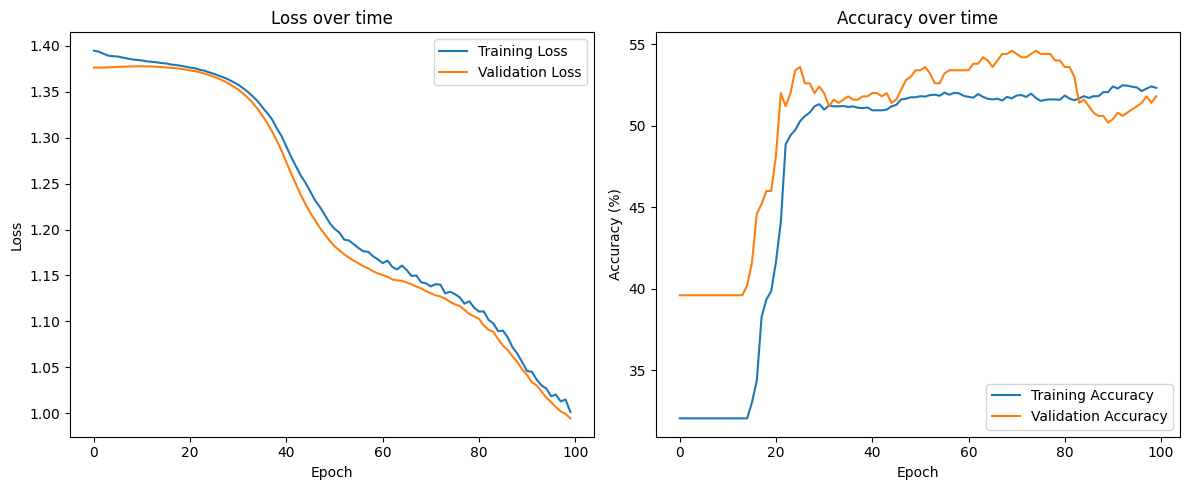

In [41]:
# Assuming trainloader and testloader are defined
EPOCHS = 100
training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for vectors, targets in trainloader:
        vectors = vectors.unsqueeze(1)  # Add channel dimension
        optimizer.zero_grad()
        outputs = model(vectors)
        loss = criterion(outputs, targets)
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        loss.backward()
        optimizer.step()
    training_losses.append(total_loss / len(trainloader))
    training_accuracies.append(100 * correct / total)
    
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for vectors, targets in testloader:
            vectors = vectors.unsqueeze(1)  # Add channel dimension
            outputs = model(vectors)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    validation_losses.append(total_loss / len(testloader))
    validation_accuracies.append(100 * correct / total)

    print(f'Epoch {epoch+1}/{EPOCHS}, Training Loss: {training_losses[-1]:.4f}, Training Accuracy: {training_accuracies[-1]:.2f}%, Validation Loss: {validation_losses[-1]:.4f}, Validation Accuracy: {validation_accuracies[-1]:.2f}%')

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Loss over time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training_accuracies, label='Training Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.title('Accuracy over time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

### 6. Build the second Model: LSTM

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

class SimpleLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(SimpleLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        
        # Fully connected layer
        self.fc1 = nn.Linear(hidden_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_dim)
        
    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        # Forward propagate the LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Take the output of the last time step
        out = out[:, -1, :]
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

# Model initialization
input_dim = 1   # Number of features per time step
hidden_dim = 64 # Number of features in the hidden state
num_layers = 1  # Number of stacked LSTM layers
output_dim = 4  # Number of output classes
model = SimpleLSTM(input_dim, hidden_dim, output_dim, num_layers)
criterion = nn.CrossEntropyLoss(weight=class_weights) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

Epoch 1/100, Training Loss: 1.3288, Training Accuracy: 36.83%, Validation Loss: 1.1964, Validation Accuracy: 51.20%
Epoch 2/100, Training Loss: 1.1995, Training Accuracy: 47.52%, Validation Loss: 1.1931, Validation Accuracy: 43.40%
Epoch 3/100, Training Loss: 1.1421, Training Accuracy: 48.23%, Validation Loss: 1.0944, Validation Accuracy: 50.80%
Epoch 4/100, Training Loss: 1.0982, Training Accuracy: 49.21%, Validation Loss: 1.0557, Validation Accuracy: 51.80%
Epoch 5/100, Training Loss: 1.0485, Training Accuracy: 49.79%, Validation Loss: 0.9861, Validation Accuracy: 52.60%
Epoch 6/100, Training Loss: 1.0194, Training Accuracy: 51.97%, Validation Loss: 0.9520, Validation Accuracy: 52.40%
Epoch 7/100, Training Loss: 1.0013, Training Accuracy: 51.17%, Validation Loss: 0.9539, Validation Accuracy: 49.40%
Epoch 8/100, Training Loss: 0.9899, Training Accuracy: 52.10%, Validation Loss: 0.9549, Validation Accuracy: 53.00%
Epoch 9/100, Training Loss: 0.9783, Training Accuracy: 52.19%, Validatio

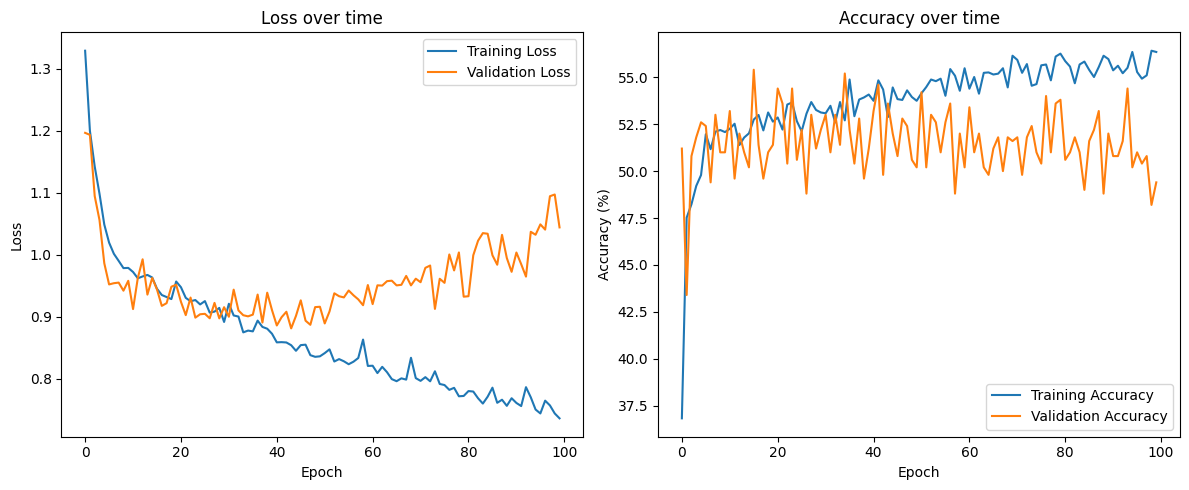

In [32]:
# Training loop
EPOCHS = 100
training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for vectors, targets in trainloader:
        vectors = vectors.unsqueeze(-1)  # Ensure input is of shape (batch_size, seq_len, input_dim)
        optimizer.zero_grad()
        outputs = model(vectors)
        loss = criterion(outputs, targets)
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        loss.backward()
        optimizer.step()
    training_losses.append(total_loss / len(trainloader))
    training_accuracies.append(100 * correct / total)
    
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for vectors, targets in testloader:
            vectors = vectors.unsqueeze(-1)  # Ensure input is of shape (batch_size, seq_len, input_dim)
            outputs = model(vectors)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    validation_losses.append(total_loss / len(testloader))
    validation_accuracies.append(100 * correct / total)

    print(f'Epoch {epoch+1}/{EPOCHS}, Training Loss: {training_losses[-1]:.4f}, Training Accuracy: {training_accuracies[-1]:.2f}%, Validation Loss: {validation_losses[-1]:.4f}, Validation Accuracy: {validation_accuracies[-1]:.2f}%')

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Loss over time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training_accuracies, label='Training Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.title('Accuracy over time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()